In [4]:
import zipfile
import os

zip_path = "/content/Ball.zip"  # Replace with your uploaded file name
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/dataset


In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542087 sha256=c82e0f55e6109afc3f7d26764170ddc440d0739b261b5b8b5ecad8346bff75dc
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [2]:
import cv2
import numpy as np
import librosa
import librosa.display
import scipy.signal
import os
import IPython.display as ipd
import random
import warnings
from moviepy.editor import VideoFileClip
from tqdm import tqdm
import pandas as pd
import librosa
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.signal import iirfilter, lfilter, find_peaks
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from itertools import product
from moviepy.editor import VideoFileClip, AudioFileClip
from scipy.signal import correlate
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linear_sum_assignment
import shutil

  if event.key is 'enter':



In [3]:
warnings.filterwarnings("ignore")

In [5]:
audio_folder = "/content/dataset/audio_only"
video_folder = "/content/dataset/video_only"

In [6]:
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav") or f.endswith(".mp3")]
video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

In [7]:
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])
box_x_min, box_y_min = 80, 60
box_x_max, box_y_max = 575, 420

In [10]:
tracking_data = []

In [11]:
for video_file in tqdm(video_files, desc="Processing Videos"):
    video_path = os.path.join(video_folder, video_file)
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    duration_per_frame = 1 / fps

    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        frame_resized = cv2.resize(frame, (640, 480))
        hsv = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_blue, upper_blue)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            (x, y), radius = cv2.minEnclosingCircle(largest_contour)
            x, y, radius = int(x), int(y), int(radius)

            timestamp = frame_number * duration_per_frame
            tracking_data.append([video_file, frame_number, timestamp, x, y, radius])

    cap.release()


Processing Videos: 100%|██████████| 45/45 [02:59<00:00,  3.99s/it]


In [12]:
df_tracking = pd.DataFrame(tracking_data, columns=["Video", "Frame", "Timestamp", "X", "Y", "Radius"])

In [13]:
df_tracking = df_tracking.sort_values(by=["Video", "Frame"], ascending=[True, True]).reset_index(drop=True)

In [14]:
df_tracking.head()

,Video,Frame,Timestamp,X,Y,Radius
0,video_only_ID_1.mp4,1,0.016667,328,238,8
1,video_only_ID_1.mp4,2,0.033333,341,237,8
2,video_only_ID_1.mp4,3,0.050000,354,233,8
3,video_only_ID_1.mp4,4,0.066667,366,231,8
4,video_only_ID_1.mp4,5,0.083333,379,230,8


In [15]:
len(df_tracking.Video.unique())

45

In [16]:
df_tracking.shape

(48741, 6)

In [17]:
collision_data = []

In [18]:
for video_file in df_tracking["Video"].unique():
    df_video = df_tracking[df_tracking["Video"] == video_file]

    prev_x, prev_y, prev_r = None, None, None

    for index, row in df_video.iterrows():
        x, y, r, timestamp = row["X"], row["Y"], row["Radius"], row["Timestamp"]

        if prev_x is not None and prev_y is not None and prev_r is not None:
            crossed_left = (prev_x - prev_r > box_x_min) and ((x - r) <= box_x_min)
            crossed_right = (prev_x + prev_r < box_x_max) and ((x + r) >= box_x_max)
            crossed_bottom = (prev_y + prev_r < box_y_max) and ((y + r) >= box_y_max)

            if crossed_left or crossed_right or crossed_bottom:
                collision_data.append([video_file, row["Frame"], timestamp, x, y])

        prev_x, prev_y, prev_r = x, y, r


In [19]:
df_collision = pd.DataFrame(collision_data, columns=["Video", "Frame", "Timestamp", "X", "Y"])

In [20]:
df_collision = df_collision.sort_values(by=["Video", "Frame"], ascending=[True, True]).reset_index(drop=True)

In [21]:
len(df_collision.Video.unique())

45

In [22]:
df_collision.head()

,Video,Frame,Timestamp,X,Y
0,video_only_ID_1.mp4,20,0.333333,571,210
1,video_only_ID_1.mp4,60,1.000000,86,266
2,video_only_ID_1.mp4,90,1.500000,443,412
3,video_only_ID_1.mp4,100,1.666667,571,377
4,video_only_ID_1.mp4,140,2.333333,85,230


In [23]:
df_collision.shape

(909, 5)

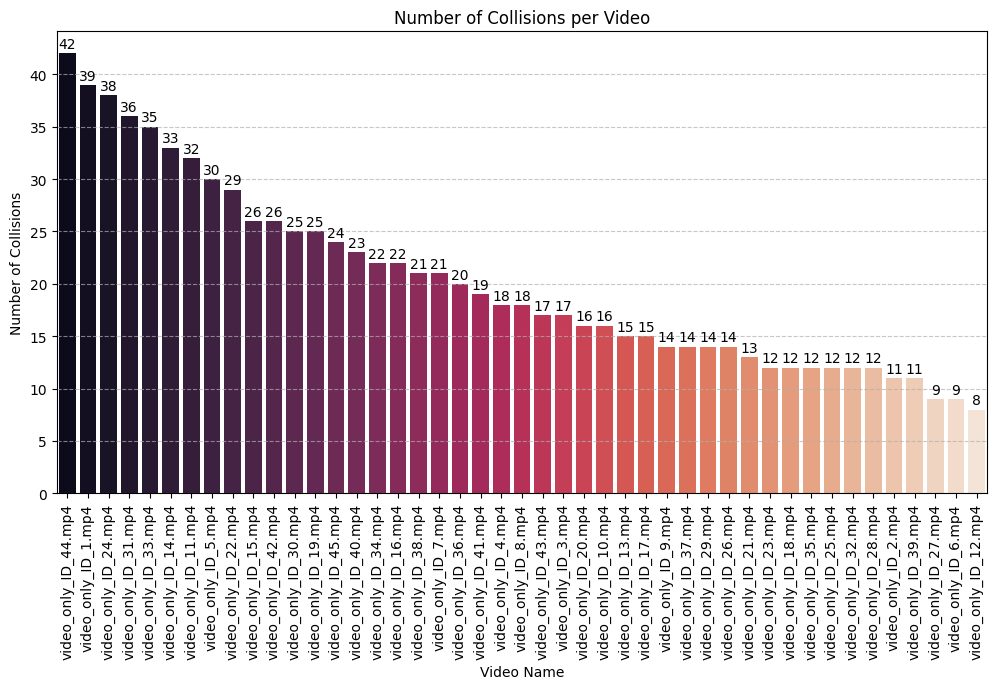

In [30]:
collision_counts = df_collision["Video"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=collision_counts.index, y=collision_counts.values, palette="rocket")

plt.xlabel("Video Name")
plt.ylabel("Number of Collisions")
plt.title("Number of Collisions per Video")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, count in enumerate(collision_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)


plt.show()

In [31]:
pitch_impulse_data = {"Audio": [], "Timestamp": []}

In [32]:
for audio_file in tqdm(os.listdir(audio_folder), desc="Processing Audio Files", unit="file"):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(audio_folder, audio_file)
        y, sr = librosa.load(audio_path, sr=None)

        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=100, fmax=5000, sr=sr)

        time_axis = librosa.frames_to_time(np.arange(len(f0)), sr=sr)

        f0 = np.nan_to_num(f0, nan=np.nanmean(f0))
        b, a = signal.iirfilter(N=4, Wn=0.01, btype="high", ftype="butter", output="ba")
        filtered_f0 = signal.filtfilt(b, a, f0)
        impulse_indices = signal.find_peaks(np.abs(filtered_f0), height=np.percentile(np.abs(filtered_f0), 90))[0]
        impulse_times = time_axis[impulse_indices]
        impulse_pitches = f0[impulse_indices]

        for t in impulse_times:
            pitch_impulse_data["Audio"].append(audio_file)
            pitch_impulse_data["Timestamp"].append(t)

Processing Audio Files: 100%|██████████| 45/45 [05:03<00:00,  6.74s/file]


In [33]:
df_pitch = pd.DataFrame(pitch_impulse_data)

In [34]:
df_pitch  = df_pitch.sort_values(by=["Audio", "Timestamp"], ascending=[True, True]).reset_index(drop=True)

In [35]:
df_pitch.head()

,Audio,Timestamp
0,audio_only_ID_1.wav,1.664
1,audio_only_ID_1.wav,2.752
2,audio_only_ID_1.wav,4.896
3,audio_only_ID_1.wav,5.824
4,audio_only_ID_1.wav,8.128


In [36]:
df_pitch.shape

(853, 2)

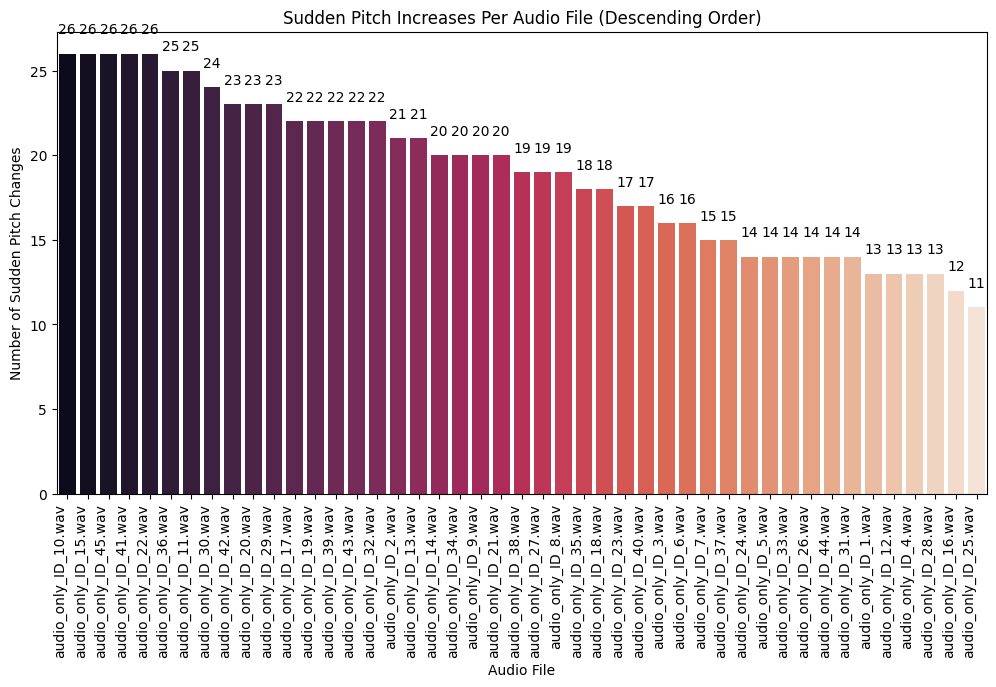

In [37]:
pitch_counts = df_pitch["Audio"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=pitch_counts.index, y=pitch_counts.values, palette="rocket")

plt.xlabel("Audio File")
plt.ylabel("Number of Sudden Pitch Changes")
plt.title("Sudden Pitch Increases Per Audio File (Descending Order)")
plt.xticks(rotation=90, ha="right")

for i, count in enumerate(pitch_counts.values):
    plt.text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)

plt.show()

In [38]:
def match_audio_video(audio_files, video_files, df_pitch, df_collision):
    best_matches = {}
    distance_matrix = []

    nn_audio = NearestNeighbors(n_neighbors=1, metric='euclidean')

    for audio_file in audio_files:
        audio_times = np.unique(df_pitch[df_pitch["Audio"] == audio_file]["Timestamp"].values)
        nn_audio.fit(audio_times.reshape(-1, 1))

        audio_distances = []
        for video_file in video_files:
            video_times = np.unique(df_collision[df_collision["Video"] == video_file]["Timestamp"].values)

            distances, _ = nn_audio.kneighbors(video_times.reshape(-1, 1))

            mean_distance = np.mean(distances)
            audio_distances.append(mean_distance)

        distance_matrix.append(audio_distances)

    distance_matrix = np.array(distance_matrix)

    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    for audio_idx, video_idx in zip(row_ind, col_ind):
        audio_file = audio_files[audio_idx]
        video_file = video_files[video_idx]
        best_matches[audio_file] = video_file

    return best_matches

In [39]:
final_mapping = match_audio_video(audio_files, video_files, df_pitch, df_collision)

In [40]:
print("Final Audio-Video Mapping:")
for audio, video in final_mapping.items():
    print(f"{audio} -> {video}")

Final Audio-Video Mapping:
audio_only_ID_16.wav -> video_only_ID_18.mp4
audio_only_ID_37.wav -> video_only_ID_29.mp4
audio_only_ID_36.wav -> video_only_ID_44.mp4
audio_only_ID_42.wav -> video_only_ID_23.mp4
audio_only_ID_32.wav -> video_only_ID_31.mp4
audio_only_ID_8.wav -> video_only_ID_32.mp4
audio_only_ID_19.wav -> video_only_ID_5.mp4
audio_only_ID_34.wav -> video_only_ID_41.mp4
audio_only_ID_18.wav -> video_only_ID_4.mp4
audio_only_ID_22.wav -> video_only_ID_45.mp4
audio_only_ID_12.wav -> video_only_ID_28.mp4
audio_only_ID_14.wav -> video_only_ID_7.mp4
audio_only_ID_2.wav -> video_only_ID_16.mp4
audio_only_ID_24.wav -> video_only_ID_12.mp4
audio_only_ID_6.wav -> video_only_ID_13.mp4
audio_only_ID_11.wav -> video_only_ID_24.mp4
audio_only_ID_1.wav -> video_only_ID_2.mp4
audio_only_ID_44.wav -> video_only_ID_9.mp4
audio_only_ID_5.wav -> video_only_ID_17.mp4
audio_only_ID_31.wav -> video_only_ID_6.mp4
audio_only_ID_30.wav -> video_only_ID_15.mp4
audio_only_ID_33.wav -> video_only_ID_2

In [48]:
import csv

# Define the CSV file name
csv_filename = "final_audio_video_mapping.csv"

# Open the file in write mode
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(["Audio File", "Video File"])

    # Write the mappings
    for audio, video in final_mapping.items():
        writer.writerow([audio, video])

print(f"CSV file '{csv_filename}' has been created successfully.")


CSV file 'final_audio_video_mapping.csv' has been created successfully.
